In [1]:
# 1. Aquisição e transformação dos dados
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import plotly.express as px
from imblearn.over_sampling import ADASYN, RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from collections import Counter
from imblearn.metrics import geometric_mean_score

r_wine = pd.read_csv('datasets/winequality-red.csv', sep = ';')
x = r_wine.iloc[:, 0:-1]
y = r_wine.iloc[:, -1]


from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=1)
x_train = np.array(x_train)
x_test = np.array(x_test)

# 3. Implementação da RNA
## 3.1 Descoberta dos hyperparâmetros (Otimização Bayseana)
# Import packages
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, KFold
from sklearn.preprocessing import scale
from sklearn.svm import SVC
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import make_scorer, roc_auc_score, accuracy_score, recall_score, f1_score
from bayes_opt import BayesianOptimization
from keras.layers import LeakyReLU
LeakyReLU = LeakyReLU(alpha=0.1)
from scikeras.wrappers import KerasClassifier
from sklearn import metrics
import math

pd.set_option("display.max_columns", None)
score_acc = make_scorer(roc_auc_score)

2022-11-29 21:51:46.057119: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-29 21:51:46.524357: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-29 21:51:46.524412: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-29 21:51:46.569182: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-29 21:51:47.836638: W tensorflow/stream_executor/platform/de

In [2]:
x_train = scale(x_train)
x_test = scale(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [3]:
def svm(c, gamma):

    svm_r = SVC(random_state=0, C=c, gamma=gamma)

    return svm_r
def evaluate_model(c, gamma):

    c = round(c, 3)
    gamma = round(gamma, 3)
    
    svm_r = svm(c, gamma)

    kf = KFold(n_splits=10, random_state=0, shuffle=True)
    score = []
    
    for train_index, test_index in kf.split(x_train):
        # print("TRAIN:", train_index, "TEST:", test_index)
        xtr, xte = x_train[train_index], x_train[test_index]
        ytr, yte = y_train[train_index], y_train[test_index]

        svm_r.fit(xtr, ytr)
        y_pred = svm_r.predict(xte)
        acc = accuracy_score(yte, y_pred)
        score.append(acc)

    score = sum(score)/len(score)
    return score

    
pbounds = {'c': (0.001,100),
            'gamma': (0.001,100)
            }

optimizer = BayesianOptimization(
    f=evaluate_model,
    pbounds=pbounds,
    verbose=2,  # verbose = 1 prints only when a maximum 
    # is observed, verbose = 0 is silent
    random_state=1
)
import warnings
warnings.filterwarnings('ignore')
from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

optimizer.maximize(init_points=60, n_iter=40,)
params_ = optimizer.max['params']
params_

|   iter    |  target   |     c     |   gamma   |
-------------------------------------------------
| 1         | 0.5672    | 41.7      | 72.03     |
| 2         | 0.4254    | 0.01244   | 30.23     |
| 3         | 0.5805    | 14.68     | 9.235     |
| 4         | 0.568     | 18.63     | 34.56     |
| 5         | 0.5697    | 39.68     | 53.88     |
| 6         | 0.5672    | 41.92     | 68.52     |
| 7         | 0.5647    | 20.45     | 87.81     |
| 8         | 0.5672    | 2.74      | 67.05     |
| 9         | 0.5697    | 41.73     | 55.87     |
| 10        | 0.5713    | 14.04     | 19.81     |
| 11        | 0.5647    | 80.07     | 96.83     |
| 12        | 0.5672    | 31.34     | 69.23     |
| 13        | 0.5647    | 87.64     | 89.46     |
| 14        | 0.5939    | 8.505     | 3.906     |
| 15        | 0.5647    | 16.98     | 87.81     |
| 16        | 0.568     | 9.836     | 42.11     |
| 17        | 0.5697    | 95.79     | 53.32     |
| 18        | 0.568     | 69.19     | 31.55     |


{'c': 22.999959360815676, 'gamma': 1.202010247169696}

In [4]:
svm_r = svm(params_['c'], params_['gamma'])

svm_r.fit(x_train, y_train)

y_pred = svm_r.predict(x_test)
svm_r.score(x_test, y_test)

0.6325

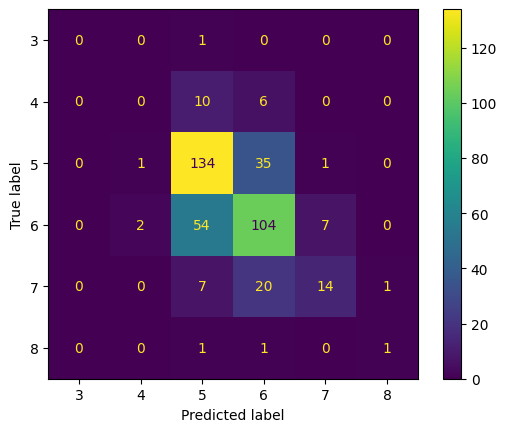

In [5]:
cm = metrics.confusion_matrix(y_test, y_pred)
cm
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [3,4,5,6,7,8])
cm_display.plot()
plt.savefig("test_svm_r.png")


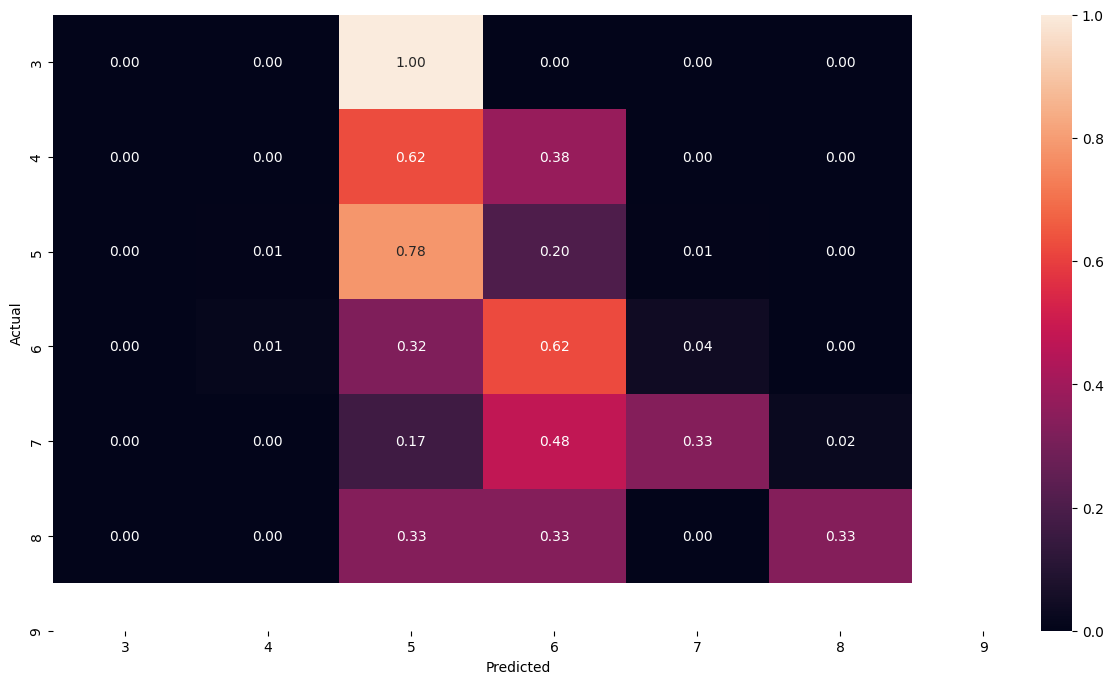

In [6]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_test, y_pred)
# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(15,8))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=[3,4,5,6,7,8,9], yticklabels=[3,4,5,6,7,8,9])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)